# GradNorm y Autoencoders Autosupervisados para Hashing Supervisado

## GradNorm

### Definiciones Preliminares
* $W$: subconjunto de pesos del la red completa. Generalmente se eligen los pesos de la ultima capa compartida entre las tareas.
* $G_W^{(i)}(t)$ = $||\nabla_W w_i(t)L_i(t)||_2$, norma $L_2$ del gradiente de la loss ponderada por el peso de la tarea.
* $\overline{G}_W(t) = E_{tasks}[G_W^{(i)}(t)]$: norma promedio de los gradientes sobre todas las tareas. 
Tasa de entrenamiento para la tarea $i$
* $\tilde{L}_i(t) = L_i(t)/L_i(0)$: loss ratio de la tarea $i$ en el tiempo $t$.
* $r_i(t) = \tilde{L}_i(t)/E_{tasks}[\tilde{L}_i(t)]$ tasa de entranamiento inversa relativa de la tarea $i$.

### Algoritmo
GradNorm trata de establecer una escala común para las magnitudes de los gradientes y también debe equilibrar las tasas de entrenamiento para las diferentes tareas. La escala común para los gradientes es la norma del gradiente promedio $\overline{G}_W(t)$, que establece una línea base en cada paso  de entrenamiento $t$ mediante el cual se puede determinar los tamaños gradientes relativos. Ahora, para equilibrar la tasa de los gradientes, se utiliza la tasa de entrenamiento inversa relacionada a la tarea $i$, $r_i(t)$. Cuanto más grande sea $r_i(t)$, mayores deberian ser las magnitudes de los gradientes para la tarea $i$ con el fin de fomentar que la tarea se entrene más rápido. Teniendo todo esto en cuenta, la norma deseada del gradiente para cada tarea $i$ es: $$G_W^{(i)} \longrightarrow \overline{G}_W(t) \times [r_i(t)]^\alpha$$

Donde $\alpha$ es un hiperparámetro adicional, que establece la resistencia de la fuerza restauradora que hace retroceder las tareas a un ritmo de entrenamiento común. En casos donde las tareas son muy diferentes en complejidad, debe utilizarse un valor más alto de $\alpha$, para imponer un equilibrio en la tasa de entrenamiento más fuerte. Cuando las tareas son más simetricas  debe utilizarse un valor de $\alpha$ más cercano a $0$.

Entonces la loss de GradNomrm para poder aprender los pesos, queda dada por: $$L_{grad}(t, w_i(t)) = \sum_i \biggr\lvert G_W^{(i)}(t) - \overline{G}_W(t) \times [r_i(t)]^\alpha \biggr\rvert_1$$


### Toy Example
Funciones a aprender para las $T$ tareas, con $ 1< i < T$:
 
\begin{equation}
f_i(x) = \sigma_i  \tanh((B+\epsilon_i)x) 
\end{equation}

* $B$: matriz constante generada con una distribución normal $N(0, 10)$, de tamaño $100 \times 250$. Las tareas comparten información a partir de esta matriz.
* $\epsilon_i$: matriz constante de dimensión ($100 \times 250$), con una distribución normal $N(0, 3.5)$.
* $\sigma_i$: son escalares fijos que establecen las escalas de las salidas $f_i$. Una escala más alta para $f_i$ induce un valor esperado más alto de pérdida al cuadrado para esa tarea. Estas tareas son más difíciles de aprender debido a las variaciones más altas en sus valores de respuesta, pero también propagan gradientes más grandes. Este escenario generalmente conduce a una dinámica de entrenamiento subóptima cuando las tareas s_i superiores dominan el entrenamiento en todas las tareas.

In [1]:
# Implementation use Tensorflow 2
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
import random
import numpy as np
from keras import backend as K
import time
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
True


In [2]:
from toyExample import createData, toyExample
# Set seed for create synthetic data
seed = 40
random.seed(seed)
Tasks = 2

B = np.random.normal(scale=10, size=(100, 250)).astype(np.float32)
epsilons = np.random.normal(scale=3.5, size=(Tasks, 100, 250)).astype(np.float32)
sigmas = [1.0, 100.0]

X, Y = createData(B, epsilons, sigmas, T = Tasks)
print('X shape: ', X.shape)
print('Y shape', Y.shape)
model = toyExample()
model.summary()

X shape:  (10000, 250)
Y shape (10000, 2, 100)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          25100       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          10100       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 100)          10100       ['dense_1[0][0]']                
                                               

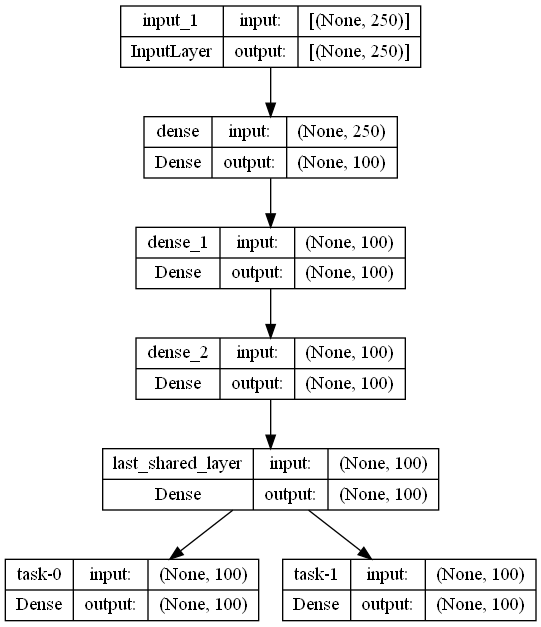

In [3]:
plot_model(model, show_shapes=True)

### Train toy example dont balancing weights

In [3]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
model_classic = toyExample()
model_classic.compile(loss='mse', 
                    loss_weights=[1.0, 1.0], #weights of tasks 1.0 , 1.0 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
h = model_classic.fit(X, [Y[:, 0, :], Y[:, 1, :]],
                            # validation_split = 0.2,
                            epochs=10,
                            batch_size=128,
                            verbose=True,
                            callbacks=[history])
history

Epoch 1/10
79/79 [==============================] - 2s 4ms/step - loss: 6261.7354 - task-0_loss: 13.6210 - task-1_loss: 6248.1133
Epoch 2/10
79/79 [==============================] - 0s 4ms/step - loss: 4660.7852 - task-0_loss: 0.5103 - task-1_loss: 4660.2754
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 4659.0166 - task-0_loss: 0.4992 - task-1_loss: 4658.5146
Epoch 4/10
79/79 [==============================] - 0s 5ms/step - loss: 4658.1548 - task-0_loss: 0.4959 - task-1_loss: 4657.6582
Epoch 5/10
79/79 [==============================] - 0s 5ms/step - loss: 4657.2266 - task-0_loss: 0.5018 - task-1_loss: 4656.7246
Epoch 6/10
79/79 [==============================] - 0s 4ms/step - loss: 4656.5249 - task-0_loss: 0.5102 - task-1_loss: 4656.0151
Epoch 7/10
79/79 [==============================] - 0s 4ms/step - loss: 4654.8467 - task-0_loss: 0.5169 - task-1_loss: 4654.3291
Epoch 8/10
79/79 [==============================] - 0s 5ms/step - loss: 4653.9653 - task-0_loss:

In [15]:
history.losses[0]

9913.05078125

2
[<AxesSubplot:> <AxesSubplot:>]
0
1


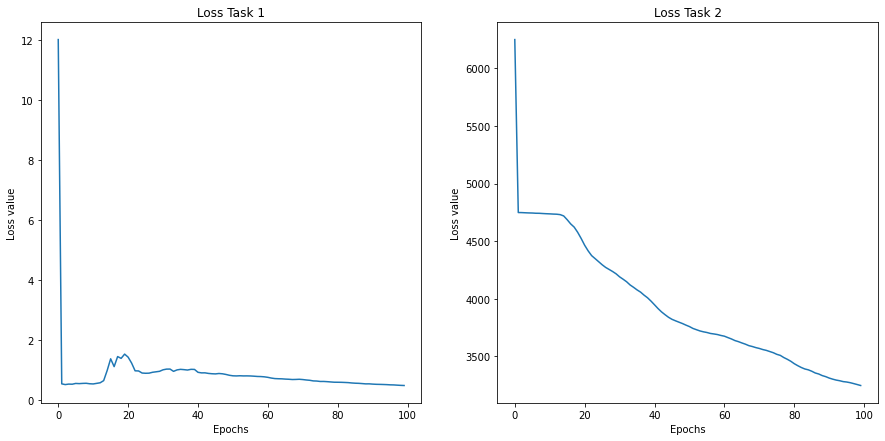

In [16]:
import matplotlib.pyplot as plt

def plotArange(rows, columns, data, xlabels, ylabels, titles, figsize=(15, 7)):
    fig, axs = plt.subplots(nrows=rows, ncols=columns,
                            figsize=figsize,
                            constrained_layout=False)
    print(len(axs))
    count = 0
    # for ax in axs:
    #     print(count)
    #     ax.plot(data[count])
    #     ax.set_xlabel(xlabels)
    #     ax.set_ylabel(ylabels)
    #     ax.set_title(titles[count])
    #     count += 1
    print(axs)
    for row in range(rows):
        for col in range(columns):
            print(count)
            axs[count].plot(data[count])
            axs[count].set_xlabel(xlabels)
            axs[count].set_ylabel(ylabels)
            axs[count].set_title(titles[count])
            count += 1
    return fig

def multiplePlot(data, xlabels, ylabels, legends, figsize=(15, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    n = len(data)
    i = 0
    for d in data:
        ax.plot(d, label=legends[i])
        ax.set_xlabel(xlabels)
        ax.set_ylabel(ylabels)
        ax.legend()
        i+=1
    return fig
        


losses = [h.history['task-0_loss'], h.history['task-1_loss']]
titles = ['Loss Task 1', 'Loss Task 2']
xlabels = 'Epochs'
ylabels = 'Loss value'
fig = plotArange(1, 2, losses, xlabels, ylabels, titles)

## GradNorm Implementation

### Toy Example With 2 Tasks

In [3]:
from gradNorm import GradNorm
losses = [tf.keras.losses.MeanSquaredError(),
          tf.keras.losses.MeanSquaredError()]
metrics = [tf.keras.metrics.Mean(),
           tf.keras.metrics.Mean()]
weights = [1.0, 1.0]
# model = toyExample()
tf.keras.backend.clear_session()
model=toyExample()

Ls, Ws = GradNorm(model, X, Y, 2, weights, losses, metrics, LR=1e-3,epochs=100, verbose=True, gradNorm=True)
# l1, l2, w1, w2


Num GPUs Available:  1
Build in CUDA:  True
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>]


AttributeError: in user code:

    File "c:\Users\jpcas\OneDrive\Documents\GitHub\GradNorm-Keras\gradNorm.py", line 85, in training_on_batch  *
        C.append(Ci)

    AttributeError: 'numpy.ndarray' object has no attribute 'append'


2
[<AxesSubplot:> <AxesSubplot:>]
0
1


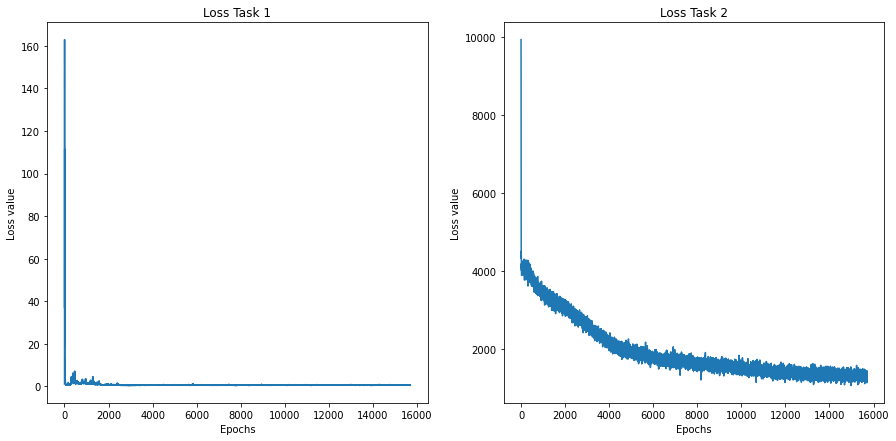

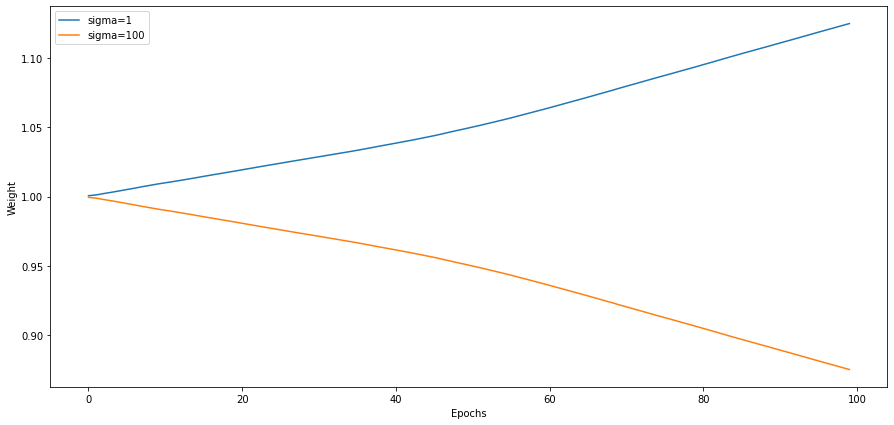

In [47]:
losses = [Ls[0], Ls[1]]
titles = ['Loss Task 1', 'Loss Task 2']
xlabels = 'Epochs'
ylabels_l = 'Loss value'
ylabels_w = 'Weight'
legends = ['sigma=1', 'sigma=100']

fig_loss = plotArange(1, 2, losses, xlabels, ylabels_l, titles)
fig_w = multiplePlot(Ws, xlabels, ylabels_w, legends)

### Toy Example with 10 Tasks

In [49]:
sigmas_10 = [48.0, 3.0, 54.0, 16.0, 9.0, 30.0, 52.0, 26.0, 47.0, 81.0]
B = np.random.normal(scale=10, size=(100, 250)).astype(np.float32)
epsilons_10 = np.random.normal(scale=3.5, size=(10, 100, 250)).astype(np.float32)
X_10, Y_10 = createData(B, epsilons_10, sigmas_10, T=10)
print('X_10 shape: ', X_10.shape)
print('Y_10 shape: ', Y_10.shape)
# losses_10 = [tf.keras.losses.MeanSquaredError() for i in range(10)]
losses = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError()]
metrics = [tf.keras.metrics.Mean() for i in range(10)]
weights = [1.0 for i in range(10)]

tf.keras.backend.clear_session()
model=toyExample(Tasks=10)

Ls_10, Ws_10 = GradNorm(model, X_10, Y_10, 10, weights, losses, metrics, LR=1e-2, epochs=100, verbose=False)

X_10 shape:  (10000, 250)
Y_10 shape:  (10000, 10, 100)
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>]
Start epoch 0


ValueError: in user code:

    File "C:\Users\jpcas\AppData\Local\Temp\ipykernel_7252\3847064306.py", line 87, in training_on_batch  *
        optimizer_model.apply_gradients(zip(grads, model.trainable_variables))
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 646, in apply_gradients  **
        self._create_all_weights(var_list)
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 858, in _create_all_weights
        _ = self.iterations
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 866, in __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1033, in iterations
        self._iterations = self.add_weight(
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1233, in add_weight
        variable = self._add_variable_with_custom_getter(
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer_utils.py", line 126, in make_variable
        return tf.compat.v1.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.
